<a href="https://colab.research.google.com/github/danil99152/prediction-of-government-tenders/blob/main/total_auction_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Import

In [1]:
!pip install catboost

     |████████████████████████████████| 69.2MB 39kB/s 


In [2]:
from datetime import datetime, date
import math
import re
import gc

import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sbs
from statsmodels.graphics.mosaicplot import mosaic

from matplotlib.ticker import MultipleLocator
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn import preprocessing
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.pipeline import make_pipeline

import xgboost as xgb
from xgboost import XGBRegressor
import catboost as ctb
from catboost import CatBoostRegressor

import joblib
import pickle

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
!gdown --id 1L6BffI4zO8ZMOtTOle3XABOXQ-5ZcfTU

Downloading...
From: https://drive.google.com/uc?id=1L6BffI4zO8ZMOtTOle3XABOXQ-5ZcfTU
To: /content/purchase_plans.csv
5.74MB [00:00, 21.8MB/s]


#Обработка данных

Считывание данных о заявках

In [55]:
contract_path = 'purchase_plans.csv'
dtypes = {'plan_number' : 'category', 
          'customer_legal_form' : 'category', 
          'KTRU' : 'category',
          'publicDiscussion' : 'category',
          'isEnergyServiceContract': 'category',
          'KVRInfo': 'category',
          'OKFS': 'category'}
data = pd.read_csv(contract_path, dtype = dtypes)
gc.collect()
data

,plan_number,customer_legal_form,OKFS,KVRInfo,positionCanceled,publicDiscussion,total,time,OKPD,log_total,maxPrice,log_maxPrice
0,201703133000188001,75403,14.0,244.0,False,False,524637.00,731,35.14.10.000,13.170462,174879.00,12.071850
1,201703133000164001,75404,14.0,244.0,False,False,30000.00,182,35.11.10.110,10.308953,11700.00,9.367344
2,201703131000014001,75103,12.0,244.0,False,False,7800000.00,1461,35.30.11.120,15.869634,2600000.00,14.771022
3,201703131000014001,75103,12.0,244.0,False,False,3675000.00,731,35.11.10.110,15.117064,1225000.00,14.018451
4,201703131000014001,75103,12.0,244.0,False,False,900000.00,731,35.30.12.120,13.710150,300000.00,12.611538
...,...,...,...,...,...,...,...,...,...,...,...,...
48641,201903131000048001,75104,12.0,244.0,False,False,572198.52,365,81.21,13.257241,572198.52,13.257241
48642,201903131000048001,75104,12.0,244.0,False,False,50000.00,365,36.00.11.000,10.819778,50000.00,10.819778
48643,201903131000048001,75104,12.0,244.0,False,False,280000.00,365,53.10,12.542545,280000.00,12.542545
48644,201903131000048001,75104,12.0,244.0,False,False,300000.00,365,43.39.1,12.611538,300000.00,12.611538


In [56]:
data = data.drop(['plan_number','log_total', 'log_maxPrice'], axis=1)

def OKPD_mapping(row):
  try:
    x, y = row.split(".", 1)
  except ValueError:
    x = row
  return x

data['OKPD'] = data['OKPD'].map(OKPD_mapping)

In [57]:
data['total_deviation'] = data['total'] - data['maxPrice']
data.dropna(inplace = True)
data = data.reset_index(drop=True)
data

,customer_legal_form,OKFS,KVRInfo,positionCanceled,publicDiscussion,total,time,OKPD,maxPrice,total_deviation
0,75403,14.0,244.0,False,False,524637.00,731,35,174879.00,349758.0
1,75404,14.0,244.0,False,False,30000.00,182,35,11700.00,18300.0
2,75103,12.0,244.0,False,False,7800000.00,1461,35,2600000.00,5200000.0
3,75103,12.0,244.0,False,False,3675000.00,731,35,1225000.00,2450000.0
4,75103,12.0,244.0,False,False,900000.00,731,35,300000.00,600000.0
...,...,...,...,...,...,...,...,...,...,...
48641,75104,12.0,244.0,False,False,572198.52,365,81,572198.52,0.0
48642,75104,12.0,244.0,False,False,50000.00,365,36,50000.00,0.0
48643,75104,12.0,244.0,False,False,280000.00,365,53,280000.00,0.0
48644,75104,12.0,244.0,False,False,300000.00,365,43,300000.00,0.0


In [58]:
#Чистим от опечаток, контрактов, которым не важна макс цена
data = data[(data['maxPrice'] > 1) & (data['total'] > 1)]

In [59]:
data['per_dev']= -np.log(data['total_deviation']/data['maxPrice'] + 1)
data.dropna(inplace = True)
data = data.reset_index(drop=True)
data

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,customer_legal_form,OKFS,KVRInfo,positionCanceled,publicDiscussion,total,time,OKPD,maxPrice,total_deviation,per_dev
0,75403,14.0,244.0,False,False,524637.00,731,35,174879.00,349758.0,-1.098612
1,75404,14.0,244.0,False,False,30000.00,182,35,11700.00,18300.0,-0.941609
2,75103,12.0,244.0,False,False,7800000.00,1461,35,2600000.00,5200000.0,-1.098612
3,75103,12.0,244.0,False,False,3675000.00,731,35,1225000.00,2450000.0,-1.098612
4,75103,12.0,244.0,False,False,900000.00,731,35,300000.00,600000.0,-1.098612
...,...,...,...,...,...,...,...,...,...,...,...
48412,75104,12.0,244.0,False,False,572198.52,365,81,572198.52,0.0,-0.000000
48413,75104,12.0,244.0,False,False,50000.00,365,36,50000.00,0.0,-0.000000
48414,75104,12.0,244.0,False,False,280000.00,365,53,280000.00,0.0,-0.000000
48415,75104,12.0,244.0,False,False,300000.00,365,43,300000.00,0.0,-0.000000


In [60]:
data = data[(data['per_dev'] < 100)]
data.dropna(inplace = True)
data = data.reset_index(drop=True)

In [61]:
data.sort_values('per_dev')

,customer_legal_form,OKFS,KVRInfo,positionCanceled,publicDiscussion,total,time,OKPD,maxPrice,total_deviation,per_dev
3984,75404,14.0,244.0,False,False,5.160000e+04,365,35,1.270000e+00,5.159873e+04,-10.612260
29273,75104,12.0,244.0,False,False,3.147594e+06,365,56,9.788000e+01,3.147496e+06,-10.378407
29310,75104,12.0,244.0,False,False,6.859735e+06,365,35,1.000170e+03,6.858735e+06,-8.833254
21739,75403,14.0,244.0,False,False,1.380000e+05,122,26,3.800000e+01,1.379620e+05,-8.197423
11816,75203,13.0,244.0,False,False,4.689839e+08,669,21,1.344750e+05,4.688494e+08,-8.156945
...,...,...,...,...,...,...,...,...,...,...,...
17735,75403,14.0,244.0,False,False,9.000000e+04,184,10,1.200000e+08,-1.199100e+08,7.195437
108,75203,13.0,244.0,False,False,1.000200e+02,365,26,1.499000e+05,-1.498000e+05,7.312353
23925,75403,14.0,244.0,False,False,2.000000e+00,61,10,1.193400e+05,-1.193380e+05,10.996585
32583,75104,12.0,223.0,False,False,1.600000e+00,285,01,9.999519e+04,-9.999359e+04,11.042874


In [62]:
data['per_dev'].describe()

count    48417.000000
mean        -0.110683
std          0.628971
min        -10.612260
25%         -0.000000
50%         -0.000000
75%         -0.000000
max         12.634878
Name: per_dev, dtype: float64

#Корреляция ОКПД и типом клиента с ценой

In [ ]:
data['total'].describe()

count    4.920400e+04
mean     3.033807e+06
std      1.161167e+08
min      1.000000e-02
25%      2.800000e+04
50%      8.756000e+04
75%      2.999925e+05
max      7.154803e+09
Name: total, dtype: float64

In [ ]:
data['log_total'].describe()

count    49204.000000
mean        11.485621
std          1.919036
min         -4.605170
25%         10.239960
50%         11.380080
75%         12.611513
max         22.691050
Name: log_total, dtype: float64

In [12]:
len(data['OKPD'].unique())

82

In [20]:
OKPD = {
    '01' : 'Продукция и услуги сельского хозяйства и охоты',
    '02' : 'Продукция лесоводства, лесозаготовок и связанные с этим услуги',
    '03' : 'Рыба и прочая продукция рыболовства и рыбоводства; услуги, связанные с рыболовством и рыбоводством',
    '05' : 'Уголь',
    '06' : 'Нефть и газ природный',
    '07' : 'Руды металлические',
    '08' : 'Продукция горнодобывающих производств прочая',
    '09' : 'Услуги в области добычи полезных ископаемых',
    '10' : 'Продукты пищевые',
    '11' : 'Напитки',
    '12' : 'Изделия табачные',
    '13' : 'Текстиль и изделия текстильные',
    '14' : 'Одежда',
    '15' : 'Кожа и изделия из кожи',
    '16' : 'Древесина и изделия из дерева и пробки, кроме мебели; изделия из соломки и материалов для плетения',
    '17' : 'Бумага и изделия из бумаги',
    '18' : 'Услуги печатные и услуги по копированию звуко- и видеозаписей, а также программных средств',
    '19' : 'Кокс и нефтепродукты',
    '20' : 'Вещества химические и продукты химические',
    '21' : 'Средства лекарственные и материалы, применяемые в медицинских целях',
    '22' : 'Изделия резиновые и пластмассовые',
    '23' : 'Продукты минеральные неметаллические прочие',
    '24' : 'Металлы основные',
    '25' : 'Изделия металлические готовые, кроме машин и оборудования',
    '26' : 'Оборудование компьютерное, электронное и оптическое',
    '27' : 'Оборудование электрическое',
    '28' : 'Машины и оборудование, не включенные в другие группировки',
    '29' : 'Средства автотранспортные, прицепы и полуприцепы',
    '30' : 'Средства транспортные и оборудование, прочие',
    '31' : 'Мебель',
    '32' : 'Изделия готовые прочие',
    '33' : 'Услуги по ремонту и монтажу машин и оборудования',
    '35' : 'Электроэнергия, газ, пар и кондиционирование воздуха',
    '36' : 'Вода природная; услуги по очистке воды и водоснабжению',
    '37' : 'Услуги по водоотведению; шлам сточных вод',
    '38' : 'Услуги по сбору, обработке и удалению отходов; услуги по утилизации отходов',
    '39' : 'Услуги по рекультивации и прочие услуги по утилизации отходов',
    '41' : 'Здания и работы по возведению зданий',
    '42' : 'Сооружения и строительные работы в области гражданского строительства',
    '43' : 'Работы строительные специализированные',
    '45' : 'Услуги по оптовой и розничной торговле и услуги по ремонту автотранспортных средств и мотоциклов',
    '46' : 'Услуги по оптовой торговле, кроме оптовой торговли автотранспортными средствами и мотоциклами',
    '47' : 'Услуги по розничной торговле, кроме розничной торговли автотранспортными средствами и мотоциклами',
    '49' : 'Услуги сухопутного и трубопроводного транспорта',
    '50' : 'Услуги водного транспорта',
    '51' : 'Услуги воздушного и космического транспорта',
    '52' : 'Услуги по складированию и вспомогательные транспортные услуги',
    '53' : 'Услуги почтовой связи и услуги курьерские',
    '55' : 'Услуги по предоставлению мест для временного проживания',
    '56' : 'Услуги общественного питания',
    '58' : 'Услуги издательские',
    '59' : 'Услуги по производству кинофильмов, видеофильмов и телевизионных программ, звукозаписей и изданию музыкальных записей',
    '60' : 'Услуги в области теле- и радиовещания',
    '61' : 'Услуги телекоммуникационные',
    '62' : 'Продукты программные и услуги по разработке программного обеспечения; консультационные и аналогичные услуги в области информационных технологий',
    '63' : 'Услуги в области информационных технологий',
    '64' : 'Услуги финансовые, кроме услуг по страхованию и пенсионному обеспечению',
    '65' : 'Услуги по страхованию, перестрахованию и негосударственному пенсионному обеспечению, кроме обязательного социального обеспечения',
    '66' : 'Услуги вспомогательные, связанные с услугами финансового посредничества и страхования',
    '68' : 'Услуги по операциям с недвижимым имуществом',
    '69' : 'Услуги юридические и бухгалтерские',
    '70' : 'Услуги головных офисов; услуги консультативные в области управления предприятием',
    '71' : 'Услуги в области архитектуры и инженерно-технического проектирования, технических испытаний, исследований и анализа',
    '72' : 'Услуги и работы, связанные с научными исследованиями и экспериментальными разработками',
    '73' : 'Услуги рекламные и услуги по исследованию конъюнктуры рынка',
    '74' : 'Услуги профессиональные, научные и технические, прочие',
    '75' : 'Услуги ветеринарные',
    '77' : 'Услуги по аренде и лизингу',
    '78' : 'Услуги по трудоустройству и подбору персонала',
    '79' : 'Услуги туристических агентств, туроператоров и прочие услуги по бронированию и сопутствующие им услуги',
    '80' : 'Услуги по обеспечению безопасности и проведению расследований',
    '81' : 'Услуги по обслуживанию зданий и территорий',
    '82' : 'Услуги в области административного, хозяйственного и прочего вспомогательного обслуживания',
    '84' : 'Услуги в области государственного управления и обеспечения военной безопасности, услуги в области обязательного социального обеспечения',
    '85' : 'Услуги в области образования',
    '86' : 'Услуги в области здравоохранения',
    '87' : 'Услуги по предоставлению ухода с обеспечением проживания',
    '88' : 'Услуги социальные без обеспечения проживания',
    '90' : 'Услуги в области творчества, искусства и развлечений',
    '91' : 'Услуги библиотек, архивов, музеев и прочие услуги в области культуры',
    '92' : 'Услуги по организации и проведению азартных игр и заключению пари, лотерей',
    '93' : 'Услуги, связанные со спортом, и услуги по организации развлечений и отдыха',
    '94' : 'Услуги общественных организаций',
    '95' : 'Услуги по ремонту компьютеров, предметов личного потребления и бытовых товаров',
    '96' : 'Услуги персональные прочие',
    '97' : 'Услуги домашних хозяйств с наемными работниками',
    '98' : 'Продукция и различные услуги частных домашних хозяйств для собственных нужд',
    '99' : 'Услуги, предоставляемые экстерриториальными организациями и органами'
    }

12358

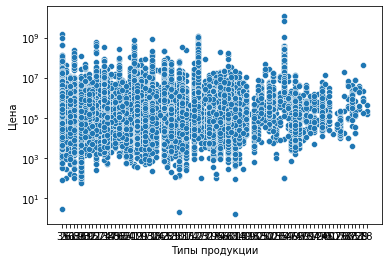

In [16]:
g = sbs.scatterplot(x = ('OKPD'), y = ('total'), data = data)
g.set(yscale = 'log', xlabel = 'Типы продукции', ylabel = 'Цена')

del g
gc.collect()

In [24]:
def OKPD_mapping(row):
  if row in OKPD:
    return OKPD[row]
  return 'Устаревшие категории'

50168

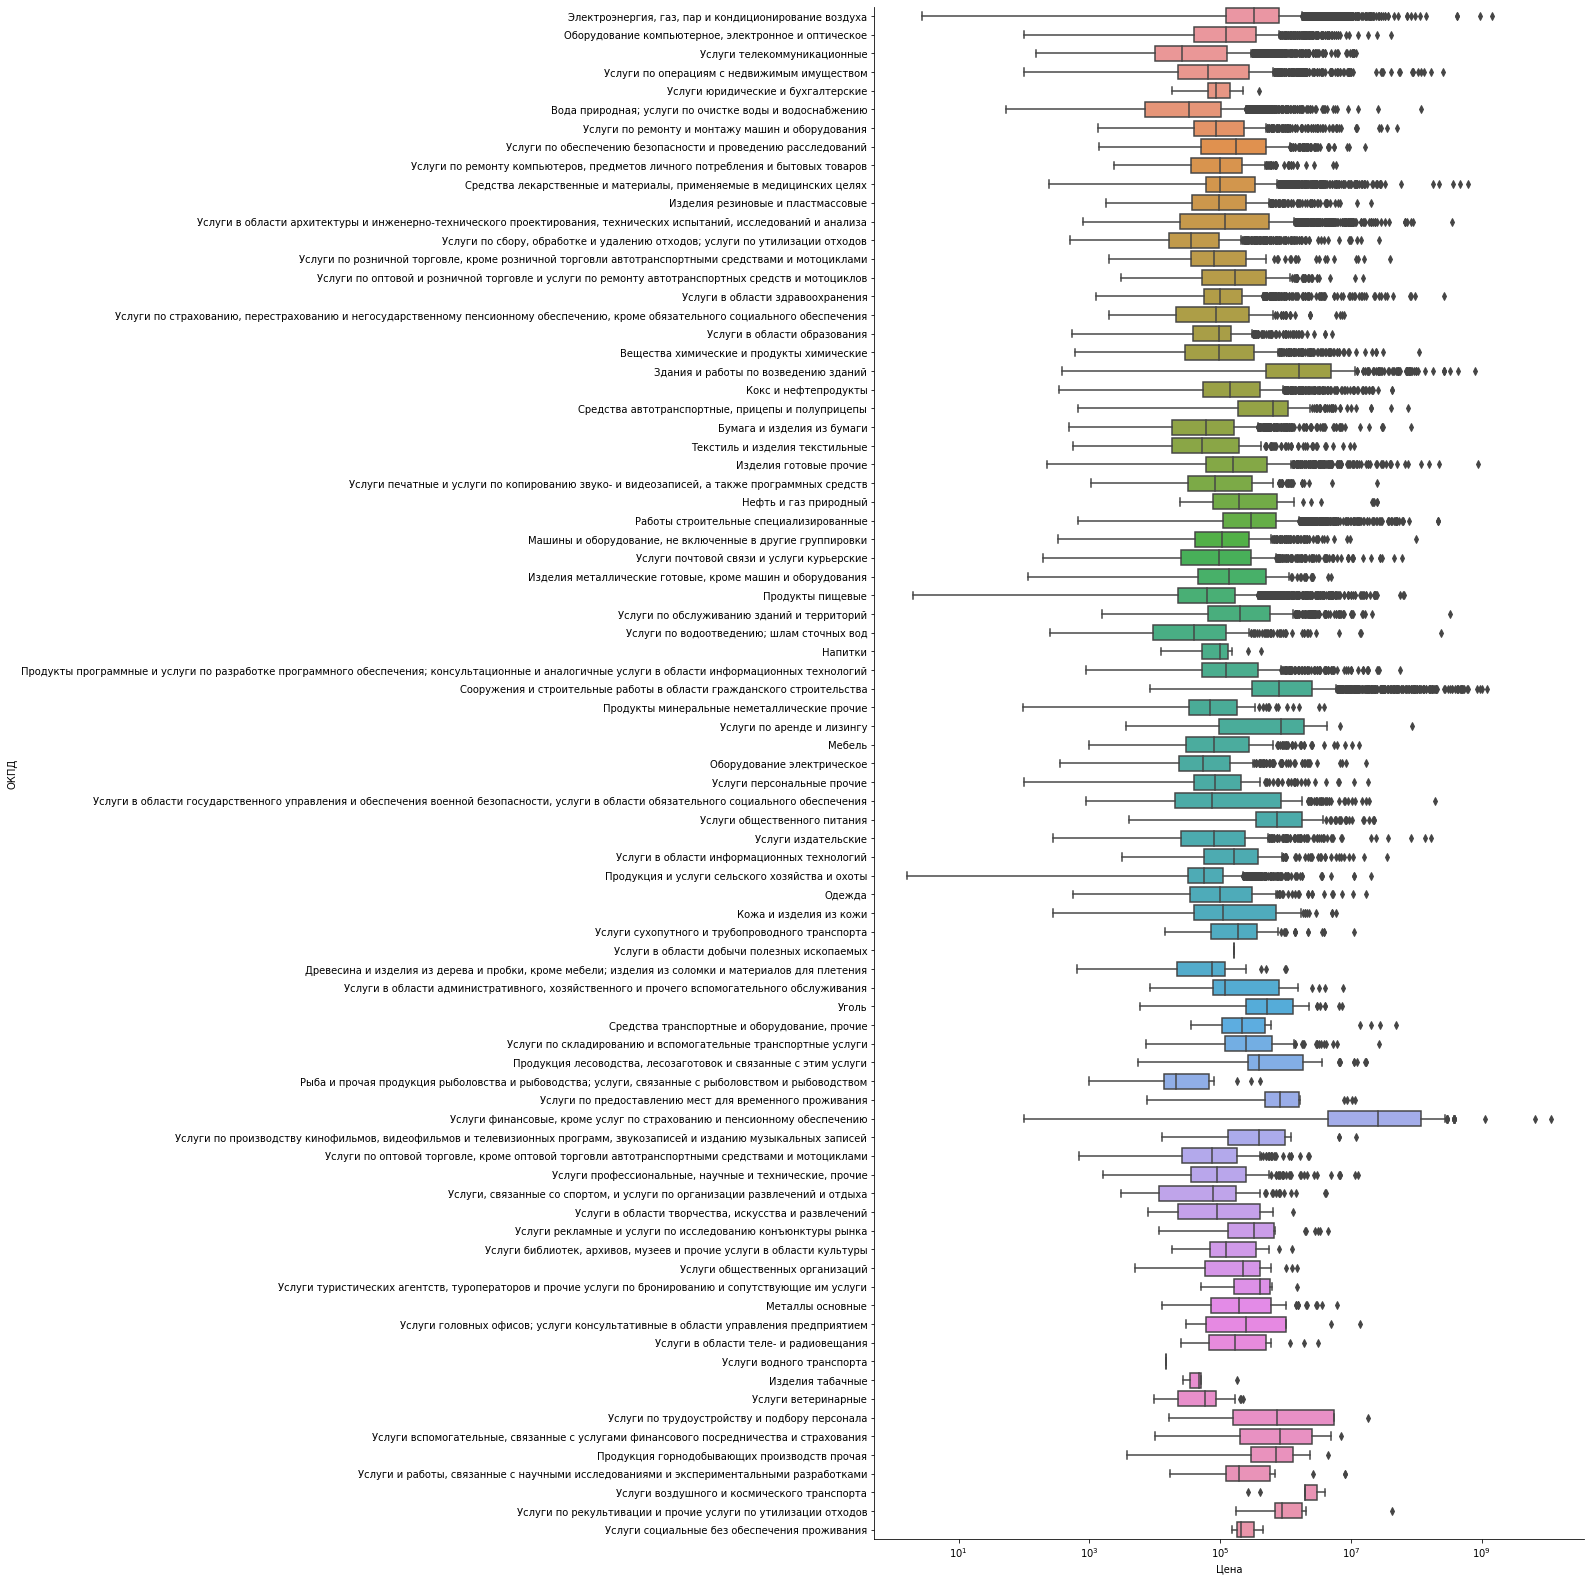

In [25]:
with sbs.plotting_context(font_scale=1.6):
  data_to_plot = data.filter(['OKPD', 'total'])
  data_to_plot['OKPD'] = data_to_plot['OKPD'].map(OKPD_mapping)
  g = sbs.catplot(y = 'OKPD', x="total", kind="box", height = 22, aspect = 1, data = data_to_plot, orient = 'h')
  g.set(xscale = 'log', xlabel = 'Цена', ylabel = 'ОКПД')

del data_to_plot
del g
gc.collect()

Цена и тип клиента

In [26]:
OKOPF = {
    '10000' : 'Юридические лица - коммерческие корпоративные организации',
    '11000' : 'Хозяйственные товарищества',
    '11051' : 'Полные товарищества',
    '11064' : 'Товарищества на вере (коммандитные товарищества)',
    '12000' : 'Хозяйственные общества',
    '12200' : 'Акционерные общества',
    '12247' : 'Публичные акционерные общества',
    '12267' : 'Непубличные акционерные общества',
    '12300' : 'Общества с ограниченной ответственностью',
    '13000' : 'Хозяйственные партнерства',
    '14000' : 'Производственные кооперативы (артели)',
    '14100' : 'Сельскохозяйственные производственные кооперативы',
    '14153' : 'Сельскохозяйственные артели (колхозы)',
    '14154' : 'Рыболовецкие артели (колхозы)',
    '14155' : 'Кооперативные хозяйства (коопхозы)',
    '14200' : 'Производственные кооперативы',
    '15300' : 'Крестьянские (фермерские) хозяйства',
    '19000' : 'Юридические лица - прочие коммерческие организации',
    '20000' : 'Юридические лица - некоммерческие корпоративные организации',
    '20100' : 'Потребительские кооперативы',
    '20101' : 'Гаражные и гаражно-строительные кооперативы',
    '20102' : 'Жилищные или жилищно-строительные кооперативы',
    '20103' : 'Жилищные накопительные кооперативы',
    '20104' : 'Кредитные потребительские кооперативы',
    '20105' : 'Кредитные потребительские кооперативы граждан',
    '20106' : 'Кредитные кооперативы второго уровня',
    '20107' : 'Потребительские общества',
    '20108' : 'Общества взаимного страхования',
    '20109' : 'Сельскохозяйственные потребительские перерабатывающие кооперативы',
    '20110' : 'Сельскохозяйственные потребительские сбытовые (торговые) кооперативы',
    '20111' : 'Сельскохозяйственные потребительские обслуживающие кооперативы',
    '20112' : 'Сельскохозяйственные потребительские снабженческие кооперативы',
    '20113' : 'Объединения фермерских хозяйств',
    '20115' : 'Сельскохозяйственные потребительские животноводческие кооперативы',
    '20121' : 'Фонды проката',
    '20200' : 'Общественные организации',
    '20201' : 'Политические партии',
    '20202' : 'Профсоюзные организации',
    '20210' : 'Общественные движения',
    '20211' : 'Органы общественной самодеятельности',
    '20217' : 'Территориальные общественные самоуправления',
    '20600' : 'Ассоциации (союзы)',
    '20601' : 'Ассоциации (союзы) экономического взаимодействия субъектов Российской Федерации',
    '20603' : 'Советы муниципальных образований субъектов РФ',
    '20604' : 'Союзы (ассоциации) кредитных кооперативов',
    '20605' : 'Союзы (ассоциации) кооперативов',
    '20606' : 'Союзы (ассоциации) общественных объединений',
    '20608' : 'Союзы потребительских обществ',
    '20609' : 'Адвокатские палаты',
    '20610' : 'Нотариальные палаты',
    '20611' : 'Торгово-промышленные палаты',
    '20612' : 'Объединения работодателей',
    '20613' : 'Объединения фермерских хозяйств',
    '20614' : 'Некоммерческие партнерства',
    '20615' : 'Адвокатские бюро',
    '20616' : 'Коллегии адвокатов',
    '20619' : 'Саморегулируемые организации',
    '20620' : 'Объединения (ассоциации и союзы) благотворительных организаций',
    '20700' : 'Товарищества собственников недвижимости',
    '20702' : 'Садоводческие или огороднические некоммерческие товарищества',
    '20716' : 'Товарищества собственников жилья',
    '20900' : 'Учреждения',
    '21100' : 'Казачьи общества',
    '21200' : 'Общины коренных малочисленных народов РФ',
    '30000' : 'Организации без прав юридического лица',
    '30001' : 'Представительства юридических лиц',
    '30002' : 'Филиалы юридических лиц',
    '30003' : 'Обособленные подразделения юридических лиц',
    '30004' : 'Структурные подразделения обособленных подразделений юридических лиц',
    '30005' : 'Паевые инвестиционные фонды',
    '30006' : 'Простые товарищества',
    '30008' : 'Районные суды, городские суды, межрайонные суды (районные суды)',
    '40000' : 'Международные организации на территории РФ',
    '40001' : 'Межправительственные международные организации',
    '40002' : 'Неправительственные международные организации',
    '50000' : 'Физическое лицо',
    '50100' : 'Организационно-правовые формы для коммерческой деятельности граждан',
    '50101' : 'Главы крестьянских (фермерских) хозяйств',
    '50102' : 'Индивидуальные предприниматели',
    '50200' : 'Организационно-правовые формы для деятельности граждан, не отнесенной к предпринимательству',
    '50201' : 'Адвокаты, учредившие адвокатский кабинет',
    '50202' : 'Нотариусы, занимающиеся частной практикой',
    '60000' : 'Юридические лица - коммерческие унитарные организации',
    '65000' : 'Унитарные предприятия',
    '65100' : 'Казенные предприятия',
    '65141' : 'Федеральные казенные предприятия',
    '65142' : 'Казенные предприятия субъектов РФ',
    '65143' : 'Муниципальные казенные предприятия',
    '65200' : 'Унитарные предприятия, основанные на праве хозяйственного ведения',
    '65241' : 'Федеральные государственные унитарные предприятия',
    '65242' : 'Государственные унитарные предприятия субъектов РФ',
    '65243' : 'Муниципальные унитарные предприятия',
    '70000' : 'Юридические лица - некоммерческие унитарные организации',
    '70400' : 'Фонды',
    '70401' : 'Благотворительные фонды',
    '70402' : 'Негосударственные пенсионные фонды',
    '70403' : 'Общественные фонды',
    '70404' : 'Экологические фонды',
    '71400' : 'Автономные некоммерческие организации',
    '71500' : 'Религиозные организации',
    '71600' : 'Публично-правовые компании',
    '71601' : 'Государственные корпорации',
    '71602' : 'Государственные компании',
    '71610' : 'Отделения иностранных некоммерческих неправительственных организаций',
    '75000' : 'Учреждения',
    '75100' : 'Учреждения, созданные Российской Федерацией',
    '75101' : 'Федеральные государственные автономные учреждения',
    '75103' : 'Федеральные государственные бюджетные учреждения',
    '75104' : 'Федеральные государственные казенные учреждения',
    '75200' : 'Учреждения, созданные субъектом РФ',
    '75201' : 'Государственные автономные учреждения субъектов РФ',
    '75203' : 'Государственные бюджетные учреждения субъектов РФ',
    '75204' : 'Государственные казенные учреждения субъектов РФ',
    '75300' : 'Государственные академии наук',
    '75400' : 'Муниципальные учреждения',
    '75401' : 'Муниципальные автономные учреждения',
    '75403' : 'Муниципальные бюджетные учреждения',
    '75404' : 'Муниципальные казенные учреждения',
    '75500' : 'Частные учреждения',
    '75502' : 'Благотворительные учреждения',
    '75505' : 'Общественные учреждения',
}

In [17]:
len(data['customer_legal_form'].unique())

18

In [31]:
def OKOPF_sub(x):
  if x in OKOPF:
    return f"({x}) {OKOPF[x]}"
  return 'Устаревшие категории'

14320

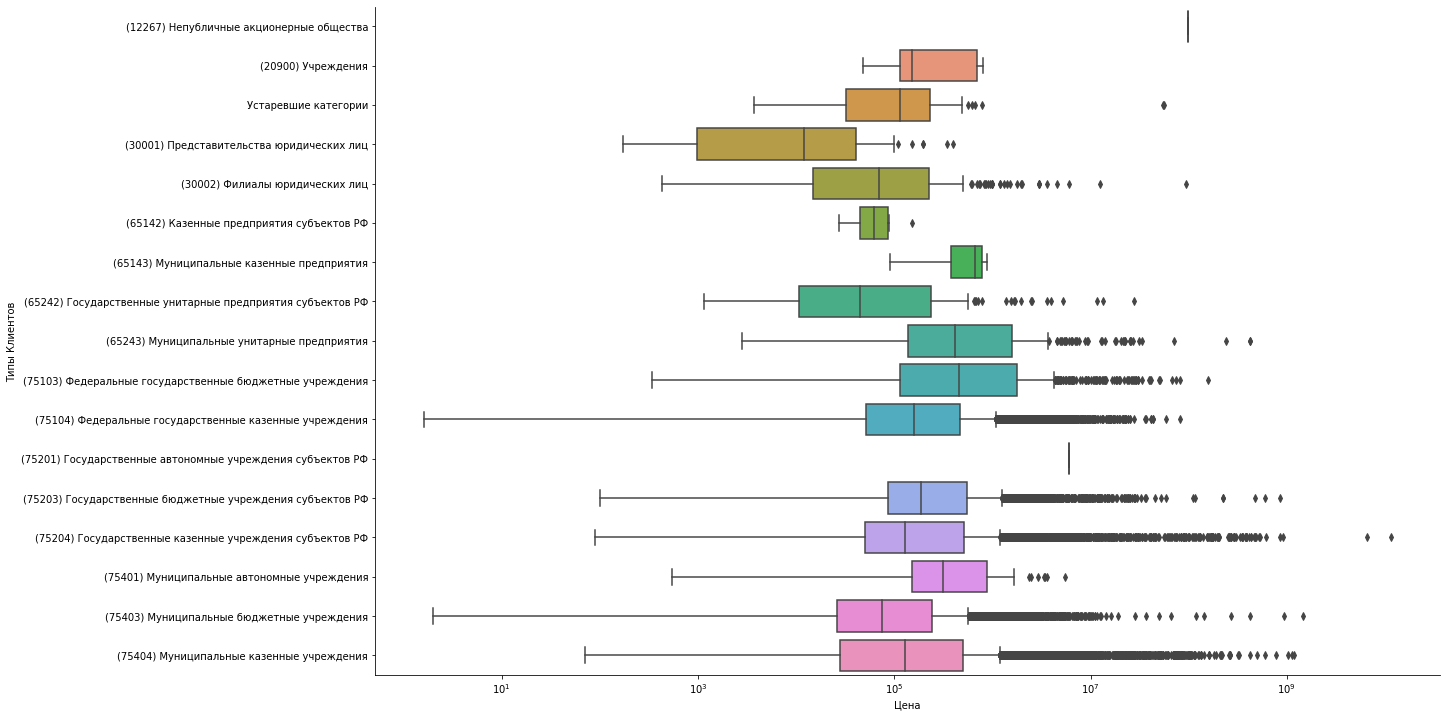

In [32]:
with sbs.plotting_context(font_scale=1.6):
  data_to_plot = data.filter(['customer_legal_form', 'total'], axis=1).sort_values('customer_legal_form')
  data_to_plot['customer_legal_form'] = data_to_plot['customer_legal_form'].map(OKOPF_sub)
  g = sbs.catplot(y = 'customer_legal_form', x = 'total', kind ='box', height = 10, aspect = 2, data = data_to_plot, orient = 'h')
  g.set(xscale = 'log', xlabel = 'Цена', ylabel = 'Типы Клиентов')
  
del data_to_plot
del g
gc.collect()

# Total:
* count    4.920400e+04
* mean     3.033807e+06
* std      1.161167e+08
* min      1.000000e-02
* 25%      2.800000e+04
* 50%      8.756000e+04
* 75%      2.999925e+05
* max      7.154803e+09

# log(total):
* count    49204.000000
* mean        11.485621
* std          1.919036
* min         -4.605170
* 25%         10.239960
* 50%         11.380080
* 75%         12.611513
* max         22.691050

# XGBoost feature importances
* [0.8741, 'customer_legal_form'],
* [0.0884, 'publicDiscussion'],
* [0.0299, 'plan_number'],
* [0.0054, 'time'],
* [0.0015, 'OKPD'],
* [0.0008, 'isEnergyServiceContract'],
* [0.0, 'positionNumber']

# CatBoost feature importances
* [36.6925, 'OKPD'],
* [34.4718, 'plan_number'],
* [23.376, 'positionNumber'],
* [3.1276, 'customer_legal_form'],
*  [2.2142, 'time'],
* [0.1179, 'publicDiscussion'],
* [0.0, 'isEnergyServiceContract']

#Прогноз цены

In [85]:
cat_var = ['customer_legal_form',
           'OKFS',
           'OKPD',
           'publicDiscussion']

* Пример: исконная цена 100, предсказанная 85, дозволенное отклонение в 1.2, соответственно на понижение (left) = -0.16, на повышение цены 0.2, отклонение = (85-100)/100 = -0.15, что входит в диапазон [-0.16; 0.2]
* Выведение формулы left и right: допустим предсказанная цена на повышение в первом случае больше в два раза - это 100% и меньше в два раза во втором - это -50%, наша const = 2. В первом случае подходит формула const-1=1(или 100%), во втором 1/сonst - 1 = -0.5 (или -50%)

In [92]:
def errors(model, x_test, y_test, total):
  y_pred = x_test['maxPrice'] - (np.exp(-(model.predict(x_test))) - 1)*x_test['maxPrice']
  const = 1.2 # отклонение в const раз
  left = 1/const - 1
  right = const - 1
  accuracy = 0
  deviation = 0
  for pred, test in zip(y_pred, total):
    deviation += np.abs(pred - test)/test
    if left <= (pred - test)/test <= right:
      accuracy += 1
  print("Average deviation:", deviation/len(y_test))
  print("Accuracy:", accuracy/len(y_test))
  # print('y_pred:', np.mean(y_pred))
  # print('y_test:', np.mean(y_test))
  # print("MSE:", metrics.mean_squared_error(y_pred, y_test))  
  # print("MSLE:", metrics.mean_squared_log_error(y_pred, y_test))
  # print("RMSLE:", np.sqrt(metrics.mean_squared_log_error(y_pred, y_test)))

In [49]:
print("Кол-во меньше 10ка:",len(data[data['total']<10000]))
print("Процент от меньше 10ка:",len(data[data['total']<10000])/len(data)*100)
print("Больше 100млн:", len(data[data['total']>=100000000]))
print("Процент от больше 100млн:", len(data[data['total']>=100000000])/len(data)*100)

Кол-во меньше 10ка: 3715
Процент от меньше 10ка: 7.672924799140797
Больше 100млн: 152
Процент от больше 100млн: 0.31393931883429377


In [ ]:
# data.drop(data[((data['total']<10000) | (data['total']>=100000000))].index, inplace=True)

In [87]:
x = data.drop(['positionCanceled', 'total', 'total_deviation', 'per_dev', 'KVRInfo'], axis=1)
y = data['per_dev']
total = train_test_split(data['total'], test_size=0.2, shuffle = False)[1]

In [88]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, shuffle = False)

In [ ]:
print(len(x_train))
print(len(y_train))

38671
38671


In [89]:
cat_features = cat_var
model_catboost = CatBoostRegressor(
    n_estimators = 100,
    learning_rate = 0.08,
    max_depth = 12,
    task_type="GPU",
    devices='0:1',
).fit(x_train, y_train, cat_features,
      eval_set=(x_test, y_test),
             use_best_model=True,
             verbose=False)
errors(model_catboost, x_test, y_test, total)

Average deviation: 0.2325289204213535
Accuracy: 0.7325485336637753


С отклонением в 1.1: Accuracy: 0.5775505989260636

In [91]:
#значимость признаков для леса
importances = model_catboost.get_feature_importance()
indices = np.argsort(importances)[::-1]
col = ['customer_legal_form', 'OKFS', 'publicDiscussion', 'time', 'OKPD', 'maxPrice']
ar_f=[]
for f, idx in enumerate(indices):
    ar_f.append([round(importances[idx],4), col[idx]])
print("Значимость признака:")
ar_f.sort(reverse=True)
ar_f

Значимость признака:


[[38.4283, 'maxPrice'],
 [20.6946, 'customer_legal_form'],
 [18.6129, 'OKPD'],
 [18.1977, 'time'],
 [3.971, 'OKFS'],
 [0.0955, 'publicDiscussion']]

In [ ]:
enc = LabelEncoder()
for param in cat_var:
  x_train.loc[:,param] = enc.fit_transform(x_train[param])
  x_test.loc[:,param] = enc.fit_transform(x_test[param])
x_train.head()

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


,plan_number,customer_legal_form,OKFS,KVRInfo,publicDiscussion,time,OKPD,maxPrice,log_maxPrice
0,645,15,2,16,0,731,1628,174879.0,12.071850
1,631,16,2,16,0,182,1605,11700.0,9.367344
2,304,9,0,16,0,1461,1644,2600000.0,14.771022
3,304,9,0,16,0,731,1605,1225000.0,14.018451
4,304,9,0,16,0,731,1648,300000.0,12.611538


In [ ]:
x_train = x_train.to_numpy().astype(float)
x_test = x_test.to_numpy().astype(float)

y_train = y_train.to_numpy().astype(float)
y_test = y_test.to_numpy().astype(float)

gc.collect()

474

In [ ]:
len(np.unique(y_train))

25301

In [ ]:
len(np.unique(y_train))

25301

In [ ]:
lin_model = LinearRegression()
lin_model.fit(x_train, y_train)
errors(lin_model, x_test, y_test)

In [ ]:
rf_model = RandomForestRegressor(n_estimators=1000, 
                               bootstrap = True,
                               warm_start = True,
                               oob_score = True)
rf_model.fit(x_train, y_train.ravel())
errors(rf_model, x_test, y_test.ravel())

In [ ]:
model = XGBRegressor(seed=42,
                      n_estimators=1000,
                      max_depth=16,
                      learning_rate=0.01)
model.fit(x_train, y_train.ravel())
errors(model, x_test, y_test.ravel())

[01:13:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Accuracy: 0.22559095580678315
y_pred: 1151461.8
y_test: 3232326.368604318
MSE: 4888029749031195.0
MSLE: 0.47877614198004026
RMSLE: 0.6919365158596851


In [ ]:
#Полиномиальная интерполяция

interpolation = make_pipeline(PolynomialFeatures(4), Ridge())
interpolation.fit(x_train, y_train)
errors(interpolation, x_test, y_test)